In [1]:

import numpy as np
import matplotlib.pyplot as plt
import random as random
import math as math
from WeinerGeneratorNumba import getWeiner, getWeinerSubset, constructWeinerSubset
from tqdm.notebook import trange, tqdm
from numba import njit
from scipy.optimize import curve_fit
import pickle

b = -0.05

t0 = 0
tend = 1
steps = 100000
dt = (tend-t0)/steps
h = 1
threshold = h/2
Kbar = 1.0

baseSteps = 1000000
Tend = 10
nRealizations = 100

def K(z):
    if z <= threshold:
        K = z*(h-2*z)*Kbar
    else:
        K = (h-z)*(-h+2*z)*Kbar
    return K
    
def dKdz(z):
    if z <= threshold:
        dKdz = h-4*z
    else:
        dKdz = 3*h-4*z
    return dKdz

def dgdz(z):
    #print(z)
    if z < threshold and z > 0:
        dgdz = math.sqrt(2) * (h - 4 * z) / (2 * math.sqrt(z * (h - 2 * z)))
    elif z > threshold and z < h:
        dgdz = math.sqrt(2) * (3 * h - 4 * z) / (2 * math.sqrt(-h**2 + 3 * h * z - 2 * z**2))
    else:
        dgdz = 0
    return dgdz

def power(x,a,b):
        return a * np.power(x, b)

def linear(x,a,b):
        return np.multiply(x,float(a)) + float(b)

class Particle():
    def __init__(self, z):
        self.z = z

    
    def simulate(self, ts, dws, dt):
        """
        Optimized simulation using static simulateNumba
        """
        self.dt = dt
        self.ts = ts
        
        self.zs = self.simulateNumba(self.z, ts, dws, dt)

        return self.zs

    def simulatePython(self, ts, dws, dt):
        """
        Slow pure Python simulation
        """
        self.dt = dt
        self.ts = ts
        self.zs = []
        for index, t in enumerate(ts):
            #Story history
            self.zs.append(self.z)

            #Advance
            z0 = self.z
            z1 = z0 + dKdz(z0)*dt + math.sqrt(2*K(z0))*dws[index] #last dws gets used here but the last resulting zs doesn't get stored

            #Store result
            self.z = z1 

            #Correct if out of bounds
            self.correctBounds()
        return self.zs

    def correctBounds(self):
        if abs(self.z) > 2*h:
            print("Severe out of bounds")
            exit()
        if self.z < 0:
            self.z = - self.z
        if self.z > h:
            self.z = 2*h - self.z
        return

    @staticmethod
    @njit
    def simulateNumba(z, ts, dws, dt):
        #Optimized version using Numba (just in time compiler)
        zs = []
        for index, t in enumerate(ts):
            #Story history
            zs.append(z)
            z0 = z

            #calc K(z0)
            if z0 <= threshold:
                K = z0*(h-2*z0)*Kbar
            else:
                K = (h-z0)*(-h+2*z0)*Kbar

            #calc dKdz(z0)
            if z0 <= threshold:
                dKdz = h-4*z0
            else:
                dKdz = 3*h-4*z0

            #K = 1 #z0
            #dKdz = 0 #1

            #Advance
            z1 = z0 + dKdz*dt + math.sqrt(2*K)*dws[index] #last dws gets used here but the last resulting zs doesn't get stored

            #Store result
            z = z1 
        
            if abs(z) > 2*h:
                print("WARNING SEVERE OUT OF BOUNDS")
            if z < 0:
                z = -z
            if z > h:
                z = 2*h - z
        return zs

    def simulateMilstein(self, ts, dws, dt):
        """
        Optimized simulation using static simulateNumba
        """
        self.dt = dt
        self.ts = ts
        
        self.zs =self.simulateMilsteinNumba(self.z, ts, dws, dt)

        return self.zs

    @staticmethod
    @njit
    def simulateMilsteinNumba(z, ts, dws, dt):
        #Optimized version using Numba (just in time compiler)
        zs = []
        for index, t in enumerate(ts):
            #Story history
            zs.append(z)
            z0 = z

            #calc K(z0)
            if z0 <= threshold:
                K = z0*(h-2*z0)*Kbar
            else:
                K = (h-z0)*(-h+2*z0)*Kbar

            #calc dKdz(z0)
            if z0 <= threshold:
                dKdz = h-4*z0
            else:
                dKdz = 3*h-4*z0

            #calc dGdz
            if z0 < threshold and z0 > 0:
                dGdz = math.sqrt(2) * (h - 4 * z0) / (2 * math.sqrt(z0 * (h - 2 * z0)))
            elif z0 > threshold and z0 < h:
                dGdz = math.sqrt(2) * (3 * h - 4 * z0) / (2 * math.sqrt(-h**2 + 3 * h * z0 - 2 * z0**2))
            else:
                dGdz = 0

            #K = 1 #z0
            #dKdz = 0 #1

            #Advance
            z1 = z0 + dKdz * dt + math.sqrt(2 * K) * dws[index] + 0.5 * math.sqrt(2 * K) * dGdz * (dws[index]*dws[index] - dt) #last dws gets used here but the last resulting zs doesn't get stored

            #Store result
            z = z1 
        
            if abs(z) > 2*h:
                print("WARNING SEVERE OUT OF BOUNDS")
            if z < 0:
                z = -z
            if z > h:
                z = 2*h - z
                
        return zs


    def simulateMilsteinPython(self,ts,dws,dt):
        self.dt = dt
        self.ts = ts
        zs = []
        for index, t in enumerate(self.ts):
            zs.append(self.z)
            z0 = self.z
            # z1 = z0 + dKdz(z0)*dt + math.sqrt(2*K(z0))*random.gauss(0,1)*math.sqrt(dt)#*randomFactor # Euler
            z1 = z0 + dKdz(z0) * dt + math.sqrt(2 * K(z0)) * dws[index] + 0.5 * math.sqrt(2 * K(z0)) * dgdz(z0) * (dws[index]**2 - dt)
            
            #Store results
            self.z = z1 

            #Correct if out of bounds
            self.correctBounds()
        return zs

In [2]:
def getParticles(type, number, baseSteps, Tend, plot = False):
    assert(type == "Euler" or type == "Milstein")
    particles = []

    for i in tqdm(range(number)):
        ts, ws, dws, dt = getWeiner(baseSteps,Tend, 0, noIO=True)

        if type == "Euler":
            eulerParticle = Particle(0.25)
            zs = eulerParticle.simulate(ts, dws, dt)
            particles.append(eulerParticle) 

        if type == "Milstein":
            milsteinParticle = Particle(0.25)
            zs = milsteinParticle.simulateMilstein(ts, dws, dt)
            particles.append(milsteinParticle)

    if plot:
        for particle in particles:
            plt.plot(particle.ts, particle.zs)
    
    return particles

def getBothTypeParticles(number, baseSteps, Tend, plot = False):
    eulerParticles = getParticles("Euler", number, baseSteps, Tend, plot = False)
    mislteinParticles = getParticles("Milstein", number, baseSteps, Tend, plot = False)
    if plot:
        for eulerParticle, milsteinParticle in zip(eulerParticles, mislteinParticles):
            plt.plot(eulerParticle.ts, eulerParticle.zs, color = 'red')
            plt.plot(milsteinParticle.ts, milsteinParticle.zs, color = 'blue')

    return eulerParticles, mislteinParticles

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

([<__main__.Particle at 0x1837e71ad60>,
  <__main__.Particle at 0x18305504700>])

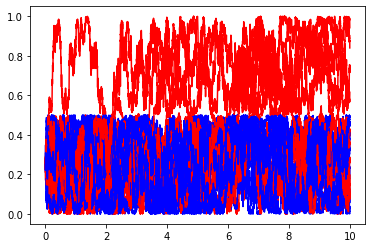

In [3]:
getBothTypeParticles(10, 10000, 10, plot = True)

In [4]:
def getProportion(type, number, baseSteps, Tend, plot = False):
    particles = getParticles(type, number, baseSteps, Tend, plot = False)
    ts = particles[0].ts
    trackLength = len(ts)

    proportionAbove  = np.zeros(trackLength)

    ones = np.ones(trackLength)
    zeros = np.zeros(trackLength)

    for particle in particles:
        track = np.array(particle.zs)

        above = np.where(track > h/2, ones, zeros)

        proportionAbove += above / number

    if plot:
        plt.plot(particles[0].ts, proportionAbove, color = 'red')

    return ts, proportionAbove

In [5]:
def getBothProportions(number, baseSteps, Tend, plot = False, **plotKwargs):
    ts, eulerProportionAbove  = getProportion("Euler", number, baseSteps, Tend, plot = False)
    ts, milsteinProportionAbove =  getProportion("Milstein", number, baseSteps, Tend, plot = False)

    if plot:
        plt.plot(ts, eulerProportionAbove, color = 'red', **plotKwargs)
        plt.plot(ts, milsteinProportionAbove, color = 'blue', **plotKwargs)

    return eulerProportionAbove, milsteinProportionAbove
        

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

(array([0.  , 0.  , 0.  , ..., 0.51, 0.51, 0.51]),
 array([0., 0., 0., ..., 0., 0., 0.]))

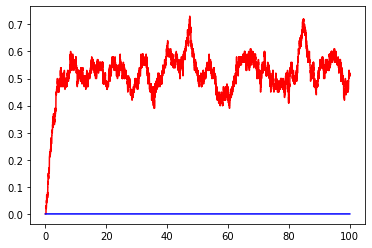

In [6]:
getBothProportions(100, 100000, 100, plot = True)

In [7]:
def blueRedGradient(max, current):
    return (1-(max-current)/max, 0, 1-current/max)

def plotProportionsOverRange(type, range, number, tend):
    for dt in range:
        numsteps = int(tend / dt)
        assert(numsteps < 10e9)
        ts, proportionAbove = getProportion(type, number, numsteps, tend)
        plt.plot(ts, proportionAbove, label = dt, color = blueRedGradient(range[-1], dt))
    plt.legend()


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

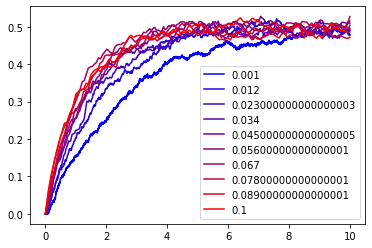

In [8]:
plotProportionsOverRange("Euler", np.linspace(10e-4, 10e-2, 10), 1000, 10)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

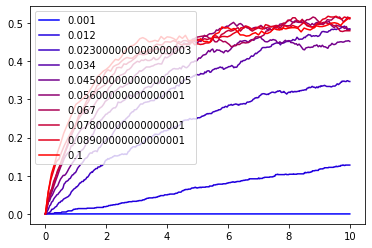

In [9]:
plotProportionsOverRange("Milstein", np.linspace(10e-4, 10e-2, 10), 1000, 10)

In [10]:
def getProportionDt(type, number, tEnd, dt, plot = False):
    steps = int(tEnd/dt)
    getProportion(type, number, steps, tEnd, plot = plot)


  0%|          | 0/1000 [00:00<?, ?it/s]

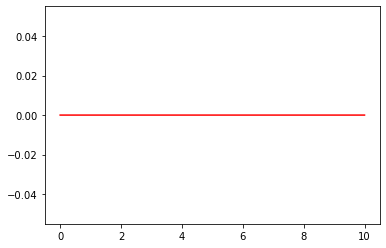

In [16]:
getProportionDt("Milstein", 1000, 10, 0.002, plot = True)

  0%|          | 0/1000 [00:00<?, ?it/s]

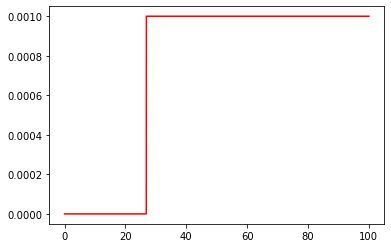

In [17]:
getProportionDt("Milstein", 1000, 100, 0.002, plot = True)